In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import datetime

import imageio
from skimage.measure import block_reduce

In [2]:
patch_size = 16
nb_channels = 3

batch_size = 32

In [3]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'

train_data_dir      = base_dir + '/tiny_train16'
validation_data_dir = base_dir + '/tiny_validation16'
test_data_dir       = base_dir + '/tiny_test16'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches in their original shape, 16x16
        patches_out -- tensor of the original patches downsampled to 8x8
    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = block_reduce(patch_in, (2, 2, 1), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
#     patches_in = np.expand_dims(patches_in, -1)  # need this if grayscale
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
#     patches_out = np.expand_dims(patches_out, -1)  # need this if grayscale
        
    print("in", patches_in.shape, "; out", patches_out.shape)
    
    return patches_in, patches_out

In [6]:
x_train, y_train = loading_data(train_data_dir)
x_validation, y_validation = loading_data(validation_data_dir)

in (157086, 16, 16, 3) ; out (157086, 8, 8, 3)
in (3932, 16, 16, 3) ; out (3932, 8, 8, 3)


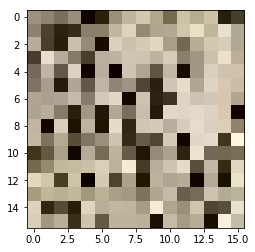

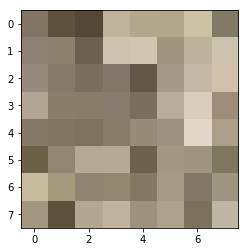

In [7]:
temp_index = np.random.randint(x_train.shape[0]) #  5429
# print(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.imshow(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.show()
plt.imshow(np.array(np.round(y_train[temp_index] * 255), dtype=np.uint8))
plt.show()

In [8]:
input_shape = (patch_size, patch_size, nb_channels)
input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation="elu", padding="same")(input_img)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
encoded = MaxPool2D((2, 2), padding="same")(x)


x = Conv2D(32, (3, 3), activation="elu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="elu", padding="same")(x)  # 32
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0     

In [9]:
image_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=False, fill_mode="nearest")

In [10]:
import wandb
from wandb.keras import WandbCallback
# os.environ['WANDB_MODE'] = 'dryrun'

In [12]:
run = wandb.init(
  project="patch-desc-ae",
  config={
    "augmentation": True,
    "elus": False,
    "last_layer_activation": "elu",
    "downsampling_output": True,
    "optimizer": "adadelta", 
    "loss": "binary_crossentropy",
    "epochs": 500 }
)

wandb: Currently logged in as: nimpy (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [13]:
%%wandb

model_version = 'patch_desc_ae_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '16_alex_3conv3mp_2020_augm_elu_lastelu_dwnsmpl'

os.system('mkdir ' + base_dir + '/weights_' + model_version)
print(base_dir + '/weights_' + model_version)

# checkpointer = ModelCheckpoint(base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = autoencoder.fit(image_datagen.flow(x_train, y_train, batch_size),
                epochs=wandb.config.epochs,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
                callbacks=[WandbCallback(data_type="image", predictions=1)]
                )
autoencoder.save(base_dir + '/' + model_version + '.h5')

# autoencoder = load_model(base_dir + '/' + model_version + '.h5')

/home/niaki/Code/ImageNet/tiny-imagenet-200/weights_patch_desc_ae_20201026_14251116_alex_3conv3mp_2020_augm_elu_lastelu_dwnsmpl
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4909 steps, validate for 123 steps
Epoch 1/500
4909/4909 [==============================] - 53s 11ms/step - loss: 2.8360 - val_loss: 1.6594
Epoch 2/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.9055 - val_loss: 0.6433
Epoch 3/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.6157 - val_loss: 0.5930
Epoch 4/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5866 - val_loss: 0.5748
Epoch 5/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5749 - val_loss: 0.5678
Epoch 6/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5701 - val_loss: 0.5639
Epoch 7/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5668 - val_loss: 0.5610
Epoch 8/500
4909/4909 [===================

4909/4909 [==============================] - 53s 11ms/step - loss: 0.5461 - val_loss: 0.5419
Epoch 76/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5461 - val_loss: 0.5416
Epoch 77/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5459 - val_loss: 0.5417
Epoch 78/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5459 - val_loss: 0.5416
Epoch 79/500
4909/4909 [==============================] - 55s 11ms/step - loss: 0.5458 - val_loss: 0.5413
Epoch 80/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5457 - val_loss: 0.5414
Epoch 81/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5456 - val_loss: 0.5412
Epoch 82/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5456 - val_loss: 0.5415
Epoch 83/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5455 - val_loss: 0.5414
Epoch 84/500
4909/4909 [==============================] - 5

Epoch 152/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5425 - val_loss: 0.5383
Epoch 153/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5425 - val_loss: 0.5382
Epoch 154/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5424 - val_loss: 0.5377
Epoch 155/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5425 - val_loss: 0.5381
Epoch 156/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5424 - val_loss: 0.5380
Epoch 157/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5424 - val_loss: 0.5382
Epoch 158/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5424 - val_loss: 0.5381
Epoch 159/500
4909/4909 [==============================] - 54s 11ms/step - loss: 0.5423 - val_loss: 0.5378
Epoch 160/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5423 - val_loss: 0.5381
Epoch 161/500
4909/4909 [============

4909/4909 [==============================] - 53s 11ms/step - loss: 0.5411 - val_loss: 0.5367
Epoch 229/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5411 - val_loss: 0.5364
Epoch 230/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5410 - val_loss: 0.5365
Epoch 231/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5410 - val_loss: 0.5368
Epoch 232/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5410 - val_loss: 0.5366
Epoch 233/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5410 - val_loss: 0.5368
Epoch 234/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5409 - val_loss: 0.5366
Epoch 235/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5410 - val_loss: 0.5366
Epoch 236/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5410 - val_loss: 0.5362
Epoch 237/500
4909/4909 [==========================

4909/4909 [==============================] - 53s 11ms/step - loss: 0.5402 - val_loss: 0.5360
Epoch 305/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5402 - val_loss: 0.5357
Epoch 306/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5402 - val_loss: 0.5357
Epoch 307/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5402 - val_loss: 0.5356
Epoch 308/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5402 - val_loss: 0.5357
Epoch 309/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5401 - val_loss: 0.5359
Epoch 310/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5401 - val_loss: 0.5359
Epoch 311/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5401 - val_loss: 0.5355
Epoch 312/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5401 - val_loss: 0.5356
Epoch 313/500
4909/4909 [==========================

4909/4909 [==============================] - 53s 11ms/step - loss: 0.5396 - val_loss: 0.5349
Epoch 381/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5396 - val_loss: 0.5354
Epoch 382/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5396 - val_loss: 0.5352
Epoch 383/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5396 - val_loss: 0.5351
Epoch 384/500
4909/4909 [==============================] - 54s 11ms/step - loss: 0.5396 - val_loss: 0.5352
Epoch 385/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5396 - val_loss: 0.5353
Epoch 386/500
4909/4909 [==============================] - 54s 11ms/step - loss: 0.5396 - val_loss: 0.5347
Epoch 387/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5396 - val_loss: 0.5351
Epoch 388/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5396 - val_loss: 0.5350
Epoch 389/500
4909/4909 [==========================

4909/4909 [==============================] - 53s 11ms/step - loss: 0.5392 - val_loss: 0.5346
Epoch 457/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5392 - val_loss: 0.5347
Epoch 458/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5392 - val_loss: 0.5347
Epoch 459/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5391 - val_loss: 0.5348
Epoch 460/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5392 - val_loss: 0.5345
Epoch 461/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5392 - val_loss: 0.5345
Epoch 462/500
4909/4909 [==============================] - 54s 11ms/step - loss: 0.5391 - val_loss: 0.5351
Epoch 463/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5391 - val_loss: 0.5348
Epoch 464/500
4909/4909 [==============================] - 53s 11ms/step - loss: 0.5391 - val_loss: 0.5345
Epoch 465/500
4909/4909 [==========================

In [15]:
history_callback.history

{'loss': [2.835962927766585,
  0.9054876392787361,
  0.6156957183404747,
  0.5865732210949762,
  0.5749019742620645,
  0.5700638790777363,
  0.5668496154821194,
  0.564619270051808,
  0.5630987527397985,
  0.5617110440661323,
  0.5605087980787189,
  0.5594879286277042,
  0.5587083600569528,
  0.5580670564071718,
  0.5574594595896321,
  0.5568869088378247,
  0.5563348340622076,
  0.5558668781311565,
  0.5553945989551575,
  0.5549592111065853,
  0.5545483394915998,
  0.5540933120988788,
  0.5537314050154467,
  0.5534101842349556,
  0.5530844328731096,
  0.5527461472690837,
  0.5524602340322057,
  0.5522245613411859,
  0.5519724155914828,
  0.5517030548838713,
  0.5514479230767731,
  0.5512394959441257,
  0.5510474202696437,
  0.5508665406670407,
  0.5506154508824919,
  0.5503849047509756,
  0.5502464646685562,
  0.5500912948001562,
  0.5499136419774844,
  0.54978436935853,
  0.5496252107583509,
  0.5494706191459948,
  0.549372846393779,
  0.5491965839955498,
  0.5490682908998533,
  0.548

predictions: 


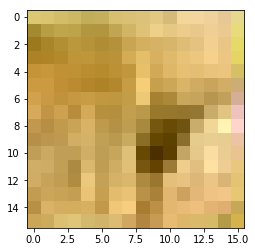

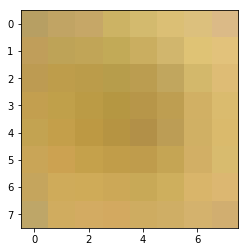

next


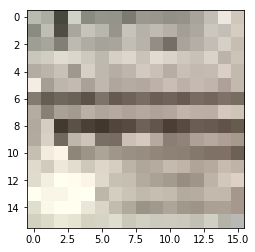

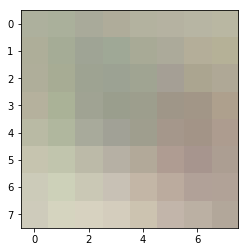

next


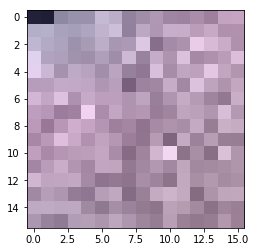

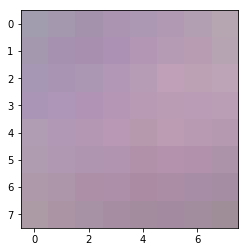

next


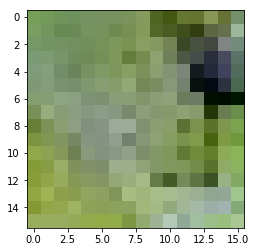

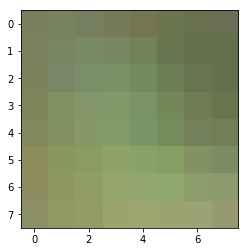

In [17]:
images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
#         img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
#         x = img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         images.append(x)
        
#         img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = autoencoder.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1, interpolation='nearest')
    plt.show()
    
    pred_1 = predictions[i].numpy()#.reshape(input_shape)
    plt.imshow(pred_1, interpolation='nearest')
    plt.show()
    
    if i > 2:
        break
    print("next")


In [18]:
encoder = Model(input_img, encoded)
for i in range(1, len(encoder.layers)):
    print(encoder.get_layer(index=i))
    encoder.get_layer(index=i).set_weights(autoencoder.get_layer(index=i).get_weights())
encoder.summary()

# encoder.save(base_dir + '/encoder' + model_version + '.h5')
encoder.save(base_dir + '/' + model_version + '__encoder.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0   

In [19]:
predictions = encoder.predict_on_batch(np.array(images))

In [24]:
predictions[3]

<tf.Tensor: shape=(2, 2, 32), dtype=float32, numpy=
array([[[ 0.07364348, -0.26372588, -0.12055302,  0.15284435,
          0.10283432,  0.04415584,  0.04411712,  0.18670505,
          0.07597279,  0.08888539,  0.298037  , -0.05283517,
          0.21595745, -0.01201248,  0.05849761, -0.03217804,
          0.14215276,  0.17074895,  0.09471261, -0.05630416,
          0.07999719,  0.1434635 , -0.01087105, -0.04012322,
          0.2391271 ,  0.28477892, -0.11913681,  0.05407385,
         -0.1386149 , -0.12280619,  0.10345373, -0.0095247 ],
        [ 0.16823539, -0.21073216,  0.0165813 ,  0.07420433,
          0.06857187,  0.1030428 ,  0.07489997,  0.08548694,
         -0.03083819,  0.12200274,  0.27344564, -0.02384108,
          0.07402854, -0.06127584,  0.11686104,  0.09849916,
          0.12508166,  0.16305153,  0.12415519,  0.07292128,
          0.11053945,  0.18250607,  0.11773908, -0.00556862,
          0.1870373 ,  0.3096376 , -0.10532689, -0.03151602,
         -0.01346529, -0.1625046

In [26]:
np.min(predictions.numpy())

-0.39439118

In [27]:
np.max(predictions.numpy())

0.62899864

In [28]:
predictions.shape

TensorShape([100, 2, 2, 32])

In [29]:
run.finish()

epoch,499
loss,0.53897
val_loss,0.53472
_step,499
_runtime,26689
_timestamp,1603745329
best_val_loss,0.53426
best_epoch,492


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


(array([ 158.,  533., 1111., 2854., 3790., 2563., 1137.,  388.,  197.,
          69.]),
 array([-0.39439118, -0.2920522 , -0.18971321, -0.08737423,  0.01496475,
         0.11730373,  0.21964271,  0.3219817 ,  0.42432067,  0.52665967,
         0.62899864], dtype=float32),
 <a list of 10 Patch objects>)

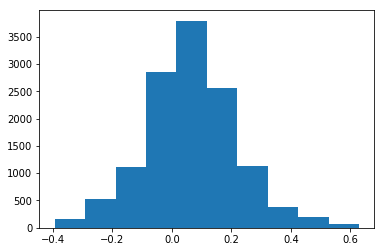

In [32]:
plt.hist(predictions.numpy().flatten())